# Load the packages and values for volume transport

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# set the grid

In [2]:
# iB = 6

path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [3]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"
dirtrsp = dirDiags + "TRSP/"

bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Mass'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

# mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
# hFacCpartial = mygrid['hFacC']
# mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
print(hf1.shape)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

DRF3d = mk3D_mod(mygrid["DRF"],np.zeros((nz, ny, nx)))

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)


In [4]:
# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

(50, 1350, 270)

In [5]:
# Copy mskBasin to mymsk
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
mask = mymsk <= 8

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


In [6]:
# 2d
inf = h5py.File(dirgridw + 'Index_wet_hfacC_2D.mat')
arr = inf['ind'][:]
iwetC2d = arr[5,:]
iwetC2d = iwetC2d.astype("int32")
iwetC2d -= 1
LwetC2d = iwetC2d.shape[0]
print("LwetC2d",LwetC2d)

# 3d
inf = h5py.File(dirgridw + "Index_wet_hfacC.mat")
arr = inf['ind'][:]
iwetC = arr[5,:]
iwetC = iwetC.astype("int32")
LwetC = iwetC.shape[0]
print("LwetC",LwetC)

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat[iwetC2d]

# hf.shape - z, y, x
# hf1.shape - 1, y, x
hfflat = np.reshape(hf,hf.flatten().shape[0])
hf3d = hfflat[iwetC]

# load the gateways
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    #mskBasin = (inf["mskBasin"])
    ggate  = inf['ggate']
    ggate2  = inf['ggate2']
    
num = 1
for i in ggate[0]:
    label = i[0][0][0]
    # print(num,label)
    num += 1
print()

num = 1
for i in ggate2[0]:
    label = (i[0][0][-2])
    # print(num,label)
    num += 1

# we have to first make a dictionary
gg = {}
ggate1 = ggate[0]
for mygate in ggate1:
    name = mygate[0][0][0][0]
    gg[name] = {}
    gg[name]['ix'] = mygate[0][0][1][0]
    gg[name]['jy'] = mygate[0][0][2][0]
    gg[name]['signu'] = mygate[0][0][3][0]
    gg[name]['signv'] = mygate[0][0][4][0]
    gg[name]['descr'] = mygate[0][0][5][0]

gg2 = {}
ggate2a = ggate2[0]
for mygate in ggate2a:
    name = mygate[0][0][4][0]
    gg2[name] = {}
    gg2[name]['ix'] = mygate[0][0][0][0]
    gg2[name]['jy'] = mygate[0][0][1][0]
    gg2[name]['signu'] = mygate[0][0][2][0]
    gg2[name]['signv'] = mygate[0][0][3][0]
    gg2[name]['descr'] = mygate[0][0][5][0]

# check with An to see if these are the same values
for igate in gg.keys():
    L = len(gg[igate]['ix'])
    ivalid = np.zeros(L)
    ind = np.empty(L)
    ind.fill(np.nan)
    indwet = np.empty(L)   # same as ind
    indwet.fill(np.nan)
    for i in range(L):
        ind[i] = (gg[igate]['jy'][i] - 1) * nx + gg[igate]['ix'][i]
        # It is quite possible some of the [ix,jy] were on land,
        # which means it would not show up in iwet2d.full:
        ii = np.where(iwetC2d == ind[i])[0]
        if len(ii) > 0:
            indwet[i] = ii[0]
            ivalid[i] = 1
        else:
            indwet[i] = np.nan

    # set it in the dictionary under the basin name
    gg[igate]['indwet'] = indwet
    gg[igate]['ivalid'] = ivalid

# check with An to see if these are the same values
for igate in gg2.keys():
    L = len(gg2[igate]['ix'])
    ivalid = np.zeros(L)
    ind = np.empty(L)
    ind.fill(np.nan)
    indwet = np.empty(L)   # same as ind
    indwet.fill(np.nan)
    for i in range(L):
        ind[i] = (gg2[igate]['jy'][i] - 1) * nx + gg2[igate]['ix'][i]
        # It is quite possible some of the [ix,jy] were on land,
        # which means it would not show up in iwet2d.full:
        ii = np.where(iwetC2d == ind[i])[0]
        if len(ii) > 0:
            indwet[i] = ii[0]
            ivalid[i] = 1
        else:
            indwet[i] = np.nan

    # set it in the dictionary under the basin name
    gg2[igate]['indwet'] = indwet
    gg2[igate]['ivalid'] = ivalid

LwetC2d 146614
LwetC 4833023



# Read the files

Here for 2014
For the salt budget we need:
- SALTDR from budg3d_snap_set2
- oceSPflx and SFLUX from budg2d_zflux_set1
- WSLTMASS, oceSflux, SRELAX from budg2d_zflux_set2
- oceSPtnd and KPPg_SLT from budg3d_kpptend_set1
- ADVr_SLT, DFrE_SLT, DFrI_SLT from budg3d_zflux_set2

In [7]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
times["2014"] = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

# ocean and ice
AB_gT=0
AB_gS=0
debug = False
ffac = 1

dt = np.array([])
for i in range(1,len(datetimes)):
    dt = np.append(dt,(datetimes[i]-datetimes[i-1]).total_seconds())

In [8]:
# we want temperature and salt
THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)

for i in range(len(tsstr)):

    # read the fldList
    file_name = 'budg3d_snap_set2'
    meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
    fldlist = np.array(meta_budg3d_snap_set2["fldList"])
    varnames = np.array(["THETADR","SALTDR"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
        
    read = [int(tsstr[i])]
    
    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m

    THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx)) * mymsk[np.newaxis,:,:]
    SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx)) * mymsk[np.newaxis,:,:]

# divide first two and second two by dt
theta = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
salt = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

for i in range(len(tsstr)):
    theta[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']
    salt[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']

for i in range(len(tsstr)-1):
    dthetadt[i,:,:,:] = (THETADR[i,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]
    dsaltdt[i,:,:,:] = (SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]

In [9]:
# surface FW flux
# rewrite with only reading in these lines, be sure to compare
oceSPflx = np.full((int(len(tsstr)),ny,nx),np.nan)       # g/m^2/s 
SFLUX = np.full((int(len(tsstr)),ny,nx),np.nan)          # g/m^2/s

meta_budg2d_zflux_set1= parsemeta(dirIn + "budg2d_zflux_set1" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg2d_zflux_set1['fldList'])
varnames = np.array(['oceSPflx','SFLUX'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # net surface Fresh-Water flux into the ocean (+=down), >0 decreases salinity
    oceSPflxi,its,meta = rdmds(dirIn + "budg2d_zflux_set1", read,returnmeta=True,rec = recs[0])
    # Net freshwater flux from atmosphere & land (+=down)
    SFLUXi,its,meta = rdmds(dirIn + "budg2d_zflux_set1", read,returnmeta=True,rec = recs[1])

    # set them in the bigger array
    oceSPflx[t] = oceSPflxi.reshape(ny,nx) * mymsk
    SFLUX[t] = SFLUXi.reshape(ny,nx) * mymsk

#####################################################
# WSLTMASS, oceSflux, SRELAX from budg2d_zflux_set2
# read WVELMASS
WSLTMASS = np.full((int(len(tsstr)),ny,nx),np.nan)       # psu.m/s
oceSflux = np.full((int(len(tsstr)),ny,nx),np.nan)       # g/m^2/s
SRELAX = np.full((int(len(tsstr)),ny,nx),np.nan)         # g/m^2/s

meta_budg2d_zflux_set2= parsemeta(dirIn + "budg2d_zflux_set2" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg2d_zflux_set2['fldList'])
varnames = np.array(['WSLTMASS','oceSflux','SRELAX'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # net surface Fresh-Water flux into the ocean (+=down), >0 decreases salinity
    WSLTMASSi,its,meta = rdmds(dirIn + "budg2d_zflux_set2", read,returnmeta=True,rec = recs[0])
    oceSfluxi,its,meta = rdmds(dirIn + "budg2d_zflux_set2", read,returnmeta=True,rec = recs[1])
    SRELAXi,its,meta = rdmds(dirIn + "budg2d_zflux_set2", read,returnmeta=True,rec = recs[2])

    # set them in the bigger array
    WSLTMASS[t] = WSLTMASSi.reshape(ny,nx) * mymsk
    oceSflux[t] = oceSfluxi.reshape(ny,nx) * mymsk
    SRELAX[t] = SRELAXi.reshape(ny,nx) * mymsk

#####################################################
# ADVr_SLT, DFrE_SLT, DFrI_SLT from budg3d_zflux_set2
ADVr_SLT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)    # psu m^3/s
DFrE_SLT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)    # psu m^3/s
DFrI_SLT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)    # psu m^3/s 

# loop and read all tsteps
meta_budg3d_zflux_set2= parsemeta(dirIn + "budg3d_zflux_set2" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg3d_zflux_set2['fldList'])
varnames = np.array(['ADVr_SLT','DFrE_SLT','DFrI_SLT'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]
    
    # Vertical Mass-Weighted Comp of Velocity
    ADVr_SLTi,its,meta = rdmds(dirIn + "budg3d_zflux_set2", read,returnmeta=True,rec = recs[0])
    DFrE_SLTi,its,meta = rdmds(dirIn + "budg3d_zflux_set2", read,returnmeta=True,rec = recs[1])
    DFrI_SLTi,its,meta = rdmds(dirIn + "budg3d_zflux_set2", read,returnmeta=True,rec = recs[2])

    ADVr_SLT[i] = ADVr_SLTi.reshape(nz,ny,nx) * mymsk[np.newaxis,:,:]
    DFrE_SLT[i] = DFrE_SLTi.reshape(nz,ny,nx) * mymsk[np.newaxis,:,:]
    DFrI_SLT[i] = DFrI_SLTi.reshape(nz,ny,nx) * mymsk[np.newaxis,:,:]

#####################################################
# oceSPtnd and KPPg_SLT from budg3d_kpptend_set1
oceSPtnd = np.full((int(len(tsstr)),nz,ny,nx),np.nan)   # g/m^2/s
KPPg_SLT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)   # psu m^3/s

file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[1] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]
    
    # Vertical Mass-Weighted Comp of Velocity
    oceSPtndi,its,meta = rdmds(dirIn + "budg3d_kpptend_set1", read,returnmeta=True,rec = recs[0])
    KPPg_SLTi,its,meta = rdmds(dirIn + "budg3d_kpptend_set1", read,returnmeta=True,rec = recs[1])

    oceSPtnd[t] = oceSPtndi.reshape(nz,ny,nx)  * mymsk[np.newaxis,:,:]
    KPPg_SLT[t] = KPPg_SLTi.reshape(nz,ny,nx)  * mymsk[np.newaxis,:,:]

#######################################################
# Advection terms for hconv
ADVx_SLT= np.full((int(len(tsstr)),nz,ny,nx),np.nan)
ADVy_SLT= np.full((int(len(tsstr)),nz,ny,nx),np.nan)
DFxE_SLT= np.full((int(len(tsstr)),nz,ny,nx),np.nan)
DFyE_SLT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)   # psu m^3/s

file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[1] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT","DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]
    
    # Vertical Mass-Weighted Comp of Velocity
    ADVx_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", read,returnmeta=True,rec = recs[0])
    ADVy_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", read,returnmeta=True,rec = recs[1])
    DFxE_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", read,returnmeta=True,rec = recs[2])
    DFyE_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", read,returnmeta=True,rec = recs[3])


    ADVx_SLT[t] = ADVx_SLTi.reshape(nz,ny,nx) * mymsk[np.newaxis,:,:]
    ADVy_SLT[t] = ADVy_SLTi.reshape(nz,ny,nx) * mymsk[np.newaxis,:,:]
    DFxE_SLT[t] = DFxE_SLTi.reshape(nz,ny,nx) * mymsk[np.newaxis,:,:]
    DFyE_SLT[t] = DFyE_SLTi.reshape(nz,ny,nx) * mymsk[np.newaxis,:,:]

In [90]:
# load runoff, evap, preci from exf_zflux_set1
EXFroff = np.full((int(len(tsstr)),ny,nx),np.nan)       # m/s
EXFpreci = np.full((int(len(tsstr)),ny,nx),np.nan)       # m/s
EXFevap = np.full((int(len(tsstr)),ny,nx),np.nan)         # m/s
EXFempmr = np.full((int(len(tsstr)),ny,nx),np.nan)

meta_budg2d_zflux_set2= parsemeta(dirIn + "exf_zflux_set1" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg2d_zflux_set2['fldList'])
varnames = np.array(['EXFroff','EXFpreci','EXFevap','EXFempmr'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # net surface Fresh-Water flux into the ocean (+=down), >0 decreases salinity
    EXFroffi,its,meta = rdmds(dirIn + "exf_zflux_set1", read,returnmeta=True,rec = recs[0])
    EXFprecii,its,meta = rdmds(dirIn + "exf_zflux_set1", read,returnmeta=True,rec = recs[1])
    EXFevapi,its,meta = rdmds(dirIn + "exf_zflux_set1", read,returnmeta=True,rec = recs[2])
    EXFempmri,its,meta = rdmds(dirIn + "exf_zflux_set1", read,returnmeta=True,rec = recs[3])

    # set them in the bigger array
    EXFroff[t] = EXFroffi.reshape(ny,nx) * mymsk
    EXFpreci[t] = EXFprecii.reshape(ny,nx) * mymsk
    EXFevap[t] = EXFevapi.reshape(ny,nx) * mymsk
    EXFempmr[t] = EXFempmri.reshape(ny,nx) * mymsk

In [10]:
landmsk = np.full(mygrid['hFacC'].shape, np.nan)
landmsk[np.isnan(mygrid['hFacC'])] = 1
landmsk[~np.isnan(mygrid['hFacC'])] = np.nan
landmsk = get_aste_tracer(landmsk,nfx,nfy)[0]

# show the domain

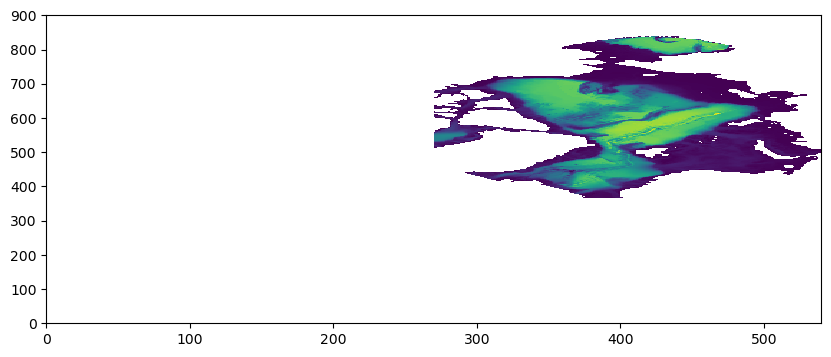

In [11]:
plt.pcolormesh(get_aste_tracer(mygrid['Depth']*mymsk,nfx,nfy)[0])

# do the TS binning

In [12]:
dirrun_small = "/scratch2/atnguyen/aste_270x450x180/run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/"

# binsTH = rdmds(dirrun_small + "layers2TH", -1)
binsTH_edges = np.linspace(-3, 12, 113)
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

coarse_section = np.linspace(0, 28, 20, endpoint=False)
refined_section = np.linspace(28, 40, 93)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

In [13]:
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(theta,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(salt,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [14]:
# also bin the time mean of theta
binned_theta_tmean = bin_array(np.nanmean(theta,axis=0),binsTH_edges)
binned_theta_tmean = binned_theta_tmean.astype(float)
binned_theta_tmean[binned_theta_tmean == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity_tmean = bin_array(np.nanmean(salt,axis=0),binsSLT_edges)
binned_salinity_tmean = binned_salinity_tmean.astype(float)
binned_salinity_tmean[binned_salinity_tmean == nS] = np.nan

/tmp/ipykernel_36790/497913866.py:2: RuntimeWarning: Mean of empty slice
  binned_theta_tmean = bin_array(np.nanmean(theta,axis=0),binsTH_edges)
/tmp/ipykernel_36790/497913866.py:5: RuntimeWarning: Mean of empty slice
  binned_salinity_tmean = bin_array(np.nanmean(salt,axis=0),binsSLT_edges)


# try to look at surface binning alone

In [15]:
WSLTMASS.shape
ADVr_SLT.shape

(13, 50, 1350, 270)

In [16]:
# bin the values in an example month to look at a TS distribution
binned_salinity[:,0,:,:].shape

summed_wslmass = np.zeros(112)

# Flatten the arrays to use np.add.at
flat_binned_salinity = binned_salinity[:,0,:,:].flatten()
flat_binned_salinity[np.isnan(flat_binned_salinity)] = 0
flat_binned_salinity = flat_binned_salinity.astype(int)
flat_wslmass = WSLTMASS.flatten()

# Use np.add.at to accumulate sums at the appropriate indices
np.add.at(summed_wslmass, flat_binned_salinity, flat_wslmass)
summed_wslmass[0] = 0

In [17]:
flat_binned_salinity3d = binned_salinity[:,:,:,:].flatten()
flat_binned_salinity3d[np.isnan(flat_binned_salinity3d)] = 0
flat_binned_salinity3d = flat_binned_salinity3d.astype(int)
flat_ADVr_SLT = ADVr_SLT.flatten()
flat_ADVr_SLT[np.isnan(flat_ADVr_SLT)] = 0

In [18]:
flat_DFrE_SLT = DFrE_SLT.flatten()
flat_DFrE_SLT[np.isnan(flat_DFrE_SLT)] = 0

In [19]:
flat_DFrI_SLT = DFrI_SLT.flatten()
flat_DFrI_SLT[np.isnan(flat_DFrI_SLT)] = 0

flat_KPPg_SLT = KPPg_SLT.flatten()
flat_KPPg_SLT[np.isnan(flat_KPPg_SLT)] = 0

In [20]:
# z conv values
summed_ADVr_SLT = np.zeros(112)
np.add.at(summed_ADVr_SLT, flat_binned_salinity3d, flat_ADVr_SLT)

summed_DFrE_SLT = np.zeros(112)
np.add.at(summed_DFrE_SLT, flat_binned_salinity3d, flat_DFrE_SLT)

summed_DFrI_SLT = np.zeros(112)
np.add.at(summed_DFrI_SLT, flat_binned_salinity3d, flat_DFrI_SLT)

summed_KPPg_SLT = np.zeros(112)
np.add.at(summed_KPPg_SLT, flat_binned_salinity3d, flat_KPPg_SLT)

In [21]:
# hconv values
flat_DFxE_SLT = DFxE_SLT.flatten()
flat_DFxE_SLT[np.isnan(flat_DFxE_SLT)] = 0

flat_DFyE_SLT = DFyE_SLT.flatten()
flat_DFyE_SLT[np.isnan(flat_DFyE_SLT)] = 0

flat_ADVx_SLT = ADVx_SLT.flatten()
flat_ADVx_SLT[np.isnan(flat_ADVx_SLT)] = 0

flat_ADVy_SLT = ADVy_SLT.flatten()
flat_ADVy_SLT[np.isnan(flat_ADVy_SLT)] = 0

In [22]:
# z conv values
summed_DFxE_SLT = np.zeros(112)
np.add.at(summed_DFxE_SLT, flat_binned_salinity3d, flat_DFxE_SLT)

summed_DFyE_SLT = np.zeros(112)
np.add.at(summed_DFyE_SLT, flat_binned_salinity3d, flat_DFyE_SLT)

summed_ADVx_SLT = np.zeros(112)
np.add.at(summed_ADVx_SLT, flat_binned_salinity3d, flat_ADVx_SLT)

summed_ADVy_SLT = np.zeros(112)
np.add.at(summed_ADVy_SLT, flat_binned_salinity3d, flat_ADVy_SLT)

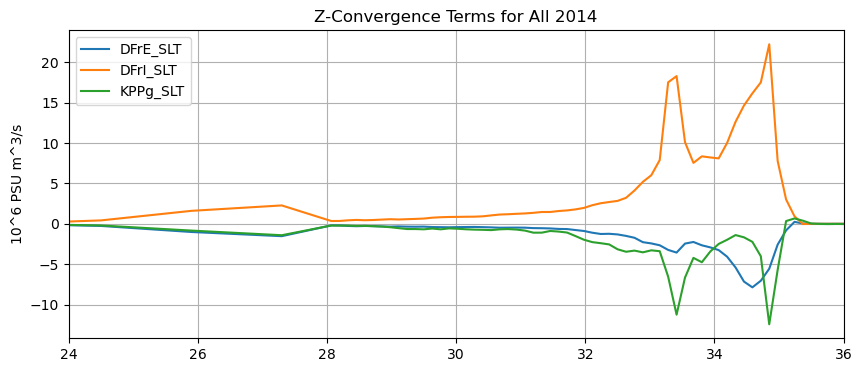

In [23]:
fig = plt.figure()
# plt.plot(binsSLT_centers,summed_wslmass,label="WSLTMASS") 
# plt.plot(binsSLT_centers,summed_ADVr_SLT/1e6,label="ADVr_SLT")
# plt.plot(binsSLT_centers,summed_DFrE_SLT/1e6 + summed_DFrI_SLT/1e6 + summed_KPPg_SLT/1e6,label="DFrE_SLT + DFrI_SLT + KPPg_SLT")
plt.plot(binsSLT_centers,summed_DFrE_SLT/1e6,label="DFrE_SLT")
plt.plot(binsSLT_centers,summed_DFrI_SLT/1e6,label="DFrI_SLT")
plt.plot(binsSLT_centers,summed_KPPg_SLT/1e6,label="KPPg_SLT")

plt.title("Z-Convergence Terms for All 2014")
plt.ylabel("10^6 PSU m^3/s")
plt.legend(loc="best")
plt.xlim(24,36)
plt.grid()

plt.savefig(path + "zconvterms_test.png",dpi=300)

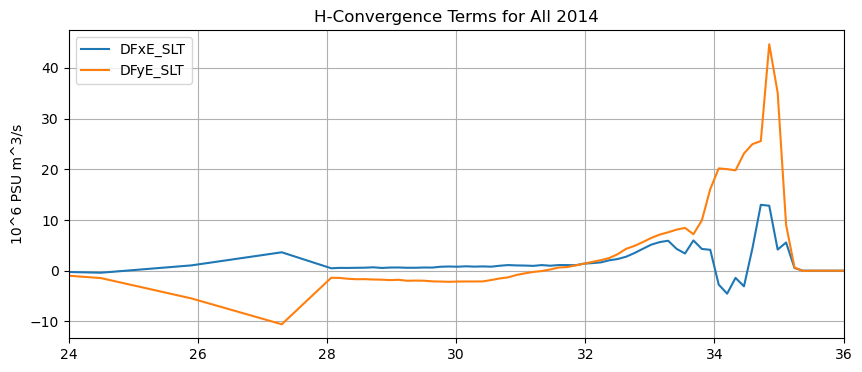

In [24]:
# bin the hconv terms (ADV SLT and DFEslt for x and y)
fig = plt.figure()
plt.plot(binsSLT_centers,summed_DFxE_SLT/1e6,label="DFxE_SLT")
plt.plot(binsSLT_centers,summed_DFyE_SLT/1e6,label="DFyE_SLT")

plt.title("H-Convergence Terms for All 2014")
plt.ylabel("10^6 PSU m^3/s")
plt.legend(loc="best")
plt.xlim(24,36)
plt.grid()

plt.savefig(path + "hconv_DFterms.png",dpi=300)

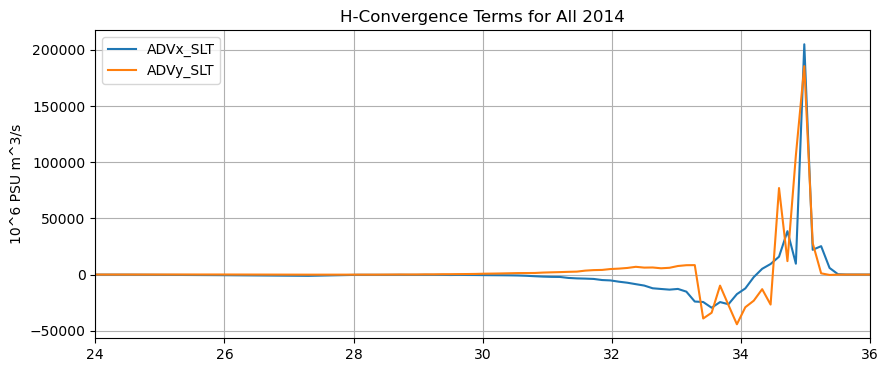

In [25]:
# bin the hconv terms (ADV SLT and DFEslt for x and y)
fig = plt.figure()
plt.plot(binsSLT_centers,summed_ADVx_SLT/1e6,label="ADVx_SLT")
plt.plot(binsSLT_centers,summed_ADVy_SLT/1e6,label="ADVy_SLT")

plt.title("H-Convergence Terms for All 2014")
plt.ylabel("10^6 PSU m^3/s")
plt.legend(loc="best")
plt.xlim(24,36)
plt.grid()

plt.savefig(path + "hconv_ADVterms.png",dpi=300)

In [26]:
# plot the tendency as a binning of salt
flat_salt = salt.flatten()
flat_salt[np.isnan(flat_salt)] = 0
summed_salt = np.zeros(112)
np.add.at(summed_salt, flat_binned_salinity3d, flat_salt)

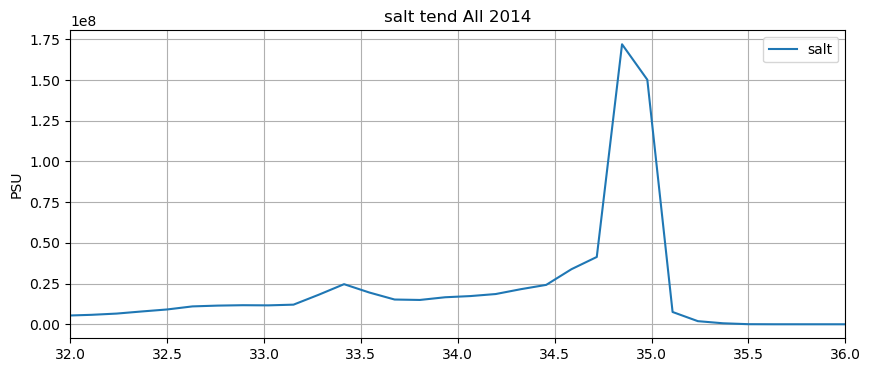

In [27]:
# bin the hconv terms (ADV SLT and DFEslt for x and y)
fig = plt.figure()
plt.plot(binsSLT_centers,summed_salt,label="salt")

plt.title("salt tend All 2014")
plt.ylabel("PSU")
plt.legend(loc="best")
plt.xlim(32,36)
plt.grid()

plt.savefig(path + "saltdr.png",dpi=300)

# Try to look at each of these convergence terms in the context of the budget

In [54]:
# look at h convergence
m = 3

tmpxo = ((ADVx_SLT[m,:,:,:]) + (DFxE_SLT[m,:,:,:]))
tmpyo = ((ADVy_SLT[m,:,:,:]) + (DFyE_SLT[m,:,:,:]))

tmpUo,tmpVo = get_aste_vector_face1_3(tmpxo,tmpyo,nfx,nfy,False)

budgO_fluxes_hconv = calc_UV_conv_1face(tmpUo[:,:-1,:-1],tmpVo[:,:-1,:-1])

In [55]:
budgO_fluxes_hconv = aste_tracer2compact(budgO_fluxes_hconv,nfx,nfy)

In [69]:
# look at z convergence
trWtop = -(ADVr_SLT[m,:,:,:]+DFrE_SLT[m,:,:,:]+DFrI_SLT[m,:,:,:]+KPPg_SLT[m,:,:,:])*myparms['rhoconst']
tmp1 = mk3D_mod(oceSPflx[m],oceSPtnd[m]) - np.cumsum(oceSPtnd[m], axis=0)
tmp1 = tmp1 * RAC3

trWtop[1:,:,:] = trWtop[1:,:,:] + tmp1[:-1,:,:]
trWtop[0,:,:] = (SFLUX[m,:,:] + oceSPflx[m,:,:]) * RAC    # top layer is surface flux

trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:] = trWtop[1:,:,:]
trWbot[-1,:,:] = 0

budgO_fluxes_zconv = trWtop - trWbot

In [76]:
np.nanmax(trWtop)

1752418.0886442424

In [58]:
# look at tendency
tmptend = myparms['rhoconst'] * (SALTDR[m+1]-SALTDR[m])/dt[m] * mk3D_mod(RAC,SALTDR[m])

In [59]:
flat_binned_salinity3d_m = binned_salinity[m,:,:,:].flatten()
flat_binned_salinity3d_m[np.isnan(flat_binned_salinity3d_m)] = 0
flat_binned_salinity3d_m = flat_binned_salinity3d_m.astype(int)

In [71]:
# bin these in salt and plot
flat_budgO_fluxes_hconv = budgO_fluxes_hconv.flatten()
flat_budgO_fluxes_hconv[np.isnan(flat_budgO_fluxes_hconv)] = 0

flat_budgO_fluxes_zconv = budgO_fluxes_zconv.flatten()
flat_budgO_fluxes_zconv[np.isnan(flat_budgO_fluxes_zconv)] = 0

flat_tmptend = tmptend.flatten()
flat_tmptend[np.isnan(flat_tmptend)] = 0

summed_budgO_fluxes_hconv = np.zeros(nS)
np.add.at(summed_budgO_fluxes_hconv, flat_binned_salinity3d_m, flat_budgO_fluxes_hconv)

summed_budgO_fluxes_zconv = np.zeros(nS)
np.add.at(summed_budgO_fluxes_zconv, flat_binned_salinity3d_m, flat_budgO_fluxes_zconv)

summed_tmptend = np.zeros(nS)
np.add.at(summed_tmptend, flat_binned_salinity3d_m, flat_tmptend)

In [72]:
np.nanmax(flat_budgO_fluxes_zconv)

0.0

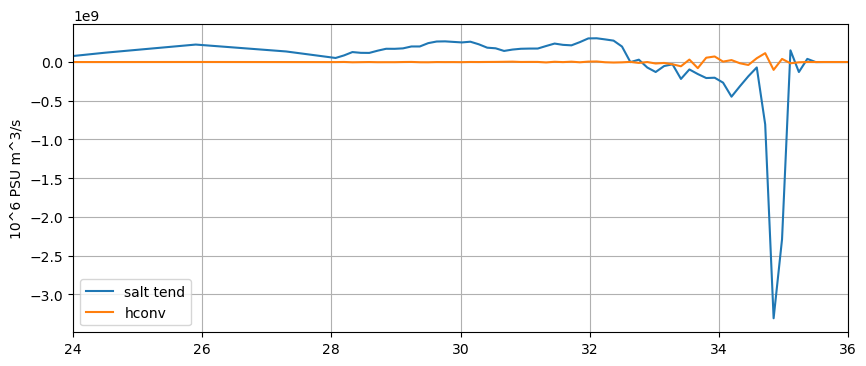

In [79]:
# bin the hconv terms (ADV SLT and DFEslt for x and y)
fig = plt.figure()
plt.plot(binsSLT_centers,summed_tmptend,label="salt tend")
# plt.plot(binsSLT_centers,summed_budgO_fluxes_zconv,label="zconv")
plt.plot(binsSLT_centers,summed_budgO_fluxes_hconv,label="hconv")


# plt.title("H-Convergence Terms for All 2014")
plt.ylabel("10^6 PSU m^3/s")
plt.legend(loc="best")
plt.xlim(24,36)
plt.grid()

# plt.savefig(path + "hconv_ADVterms.png",dpi=300)

# try to look just at sea ice formation, runoff, evaporation, surface salinity restoring forcign

In [91]:
flat_EXFroff  = EXFroff.flatten()
flat_EXFroff[np.isnan(flat_EXFroff)] = 0

flat_EXFevap = EXFevap.flatten()
flat_EXFevap[np.isnan(flat_EXFevap)] = 0

flat_EXFpreci = EXFpreci.flatten()
flat_EXFpreci[np.isnan(flat_EXFpreci)] = 0

flat_EXFempmr = EXFempmr.flatten()
flat_EXFempmr[np.isnan(flat_EXFempmr)] = 0

summed_EXFroff = np.zeros(nS)
np.add.at(summed_EXFroff, flat_binned_salinity, flat_EXFroff)

summed_EXFevap = np.zeros(nS)
np.add.at(summed_EXFevap, flat_binned_salinity, flat_EXFevap)

summed_EXFpreci = np.zeros(nS)
np.add.at(summed_EXFpreci, flat_binned_salinity, flat_EXFpreci)

summed_EXFempmr = np.zeros(nS)
np.add.at(summed_EXFempmr, flat_binned_salinity, flat_EXFempmr)

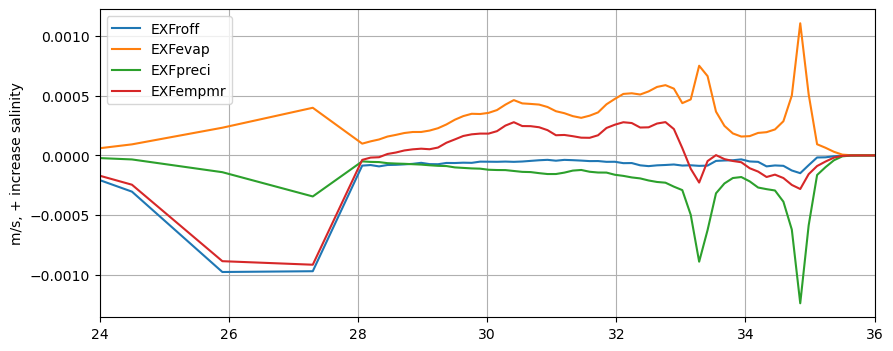

In [93]:
# bin the hconv terms (ADV SLT and DFEslt for x and y)
fig = plt.figure()
plt.plot(binsSLT_centers,-summed_EXFroff,label="EXFroff")
plt.plot(binsSLT_centers,summed_EXFevap,label="EXFevap")
plt.plot(binsSLT_centers,-summed_EXFpreci,label="EXFpreci")
plt.plot(binsSLT_centers,summed_EXFempmr,label="EXFempmr")

# plt.title("H-Convergence Terms for All 2014")
plt.ylabel("m/s, + increase salinity")
plt.legend(loc="best")
plt.xlim(24,36)
plt.grid()

plt.savefig(path + "EXF_terms.png",dpi=300)

# try to look at more plots for the salt